# AdaBoost

Let us implement the AdaBoost algorithm, to build a powerful emsemble classifier from a set of weaker classifiers. Our base classifier will be a decision stump.

The training algorithm we will implement is as follows. We have $N$ training datapoints and are creating an ensemble of $k$ classifiers.

- Initialize the weights for all datapoints ($w_j = 1/N$ for $j=1,2,...N$)
- For $i = 1$ to $k$
    - Form training set $D_i$ by sampling $N$ tuples (with replacement) from the full training dataset. The sampling probability for a tuple $(x_j,y_j)$ should be given by its corresponding weight $w_j$.
    - Use dataset $D_i$ to fit a decision stump $M_i$. You can use sklearn's DecisionTreeClassifier with max_depth=1 to fit a decision stump.
    - Calculate the error rate for $M_i$ using the sum of the weights of the misclassified points.
    $$err(M_i) = \sum_{j=1}^N w_j * \mathbb{1}\{y_j \ne M_i(x_j)\}$$
    - The weight of classifier $M_i$'s vote is computed as $\alpha_i = 0.5*\log(\frac{1-err(M_i)}{err(M_i)})$
    - Increase the weight of the misclassified training points, and decrease the weight of the correctly classified training points.
    $$w_j \leftarrow w_j * \exp\{- \alpha_i * y_j * M_i(x_j)\}$$
    - Remember to normalize the weights so that they sum to 1.

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 0

In [ ]:
# Import the libraries / functions that you use in your solution
from math import log, exp
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def train_AdaBoost(X, y, k):
    
    classifiers = []
    alphas = []
    
    ### BEGIN SOLUTION
    
    N = X.shape[0]
    D = np.concatenate((X, y.reshape(-1, 1)), axis=1)
    
    # Initialize weights

    w = np.full(N, 1/N)
    
    for i in range(k):
        
        # Fix Random Seed
        
        np.random.seed(SEED)
        
        # Sample from the dataset according to weights 
        idx = np.random.choice(N, 
                               size=N,
                               replace=True,
                               p=w)
        D_i = D[idx, :]
        
        # Fit a decision stump
        
        X_i = D_i[:,:-1]
        y_i = D_i[:,-1]
        
        stump = DecisionTreeClassifier(max_depth=1, random_state=SEED)
        stump.fit(X_i, y_i)
        
        # Calculate the error rate
        
        predictn = stump.predict(X_i)
        mis_classif = (predictn != y_i)
        
        err = np.sum(w[mis_classif])
        
        # Calculate the weight of classifier's vote

        alp = 0.5*log((1-err)/err)
        
        # Increase the weight of misclassified points

        w_idx = np.unique(idx)       
        
        for n in w_idx:
            y_pred = stump.predict(X[n, :].reshape(-1, 2))
            w[n] *= exp(-alp*y[n]*y_pred)  
        
        # Normalize the weights
        
        w *= 1/np.sum(w)
        
        # Append your classifier to the list classifiers
        
        classifiers.append(stump)
        
        # Append your alpha to the list alphas
        
        alphas.append(alp)
        
    ### END SOLUTION
    
    # classifiers and alphas need of be of type <class 'list'>
    return classifiers, alphas

To obtain predictions, the vote of each classifier $M_i$ is weighted by its corresponding coefficient $\alpha_i$.

$$y_i = \text{sign}\{\sum_{i=1}^k \alpha_i*M_i(x_i)\}$$

In [ ]:
def predict_AdaBoost(X, models, alps):

    ### BEGIN SOLUTION
    N, prediction = X.shape[0], np.zeros((X.shape[0], 1))

    for model, alp in zip(models, alps):
        prediction += model.predict(X).reshape(-1, 1) * alp

    y_predn = np.sign(prediction).reshape(-1,)

    ### END SOLUTION

    # y_pred needs to be of type <class 'numpy.ndarray'>
    return y_predn

The below function will help you plot the decision surface given by the algorithm.

In [ ]:
def plot_AdaBoost(X, y, classifiers, alphas):
    
    # Get limits of x and y for plotting the decision surface
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    # Get points at a distance of h between the above limits 
    h = .02    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    temp = np.c_[xx.ravel(), yy.ravel()]
    
    # Classify the all the points
    P = predict_AdaBoost(temp, classifiers, alphas).reshape(yy.shape)
    
    # Plot the decision boundary and margin
    plt.pcolormesh(xx, yy, P, cmap=plt.cm.coolwarm, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,edgecolor='k')
    plt.show()

Load the given datasets.

In [ ]:
X_train = pd.read_csv("X_train.csv").values
y_train = pd.read_csv("y_train.csv").values

X_test = pd.read_csv("X_test.csv").values
y_test = pd.read_csv("y_test.csv").values

Plot the training data as a scatter plot.

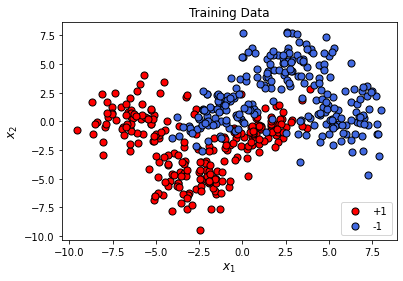

In [ ]:
pc = (y_train==1).squeeze()
nc = (y_train==-1).squeeze()

plt.scatter(X_train[pc, 0], X_train[pc, 1], color='r', edgecolors='black', s=50, alpha=1, label='+1')
plt.scatter(X_train[nc, 0], X_train[nc, 1], color='royalblue', edgecolors='black', s=50, alpha=1, label='-1')
plt.legend(loc="lower right")
plt.xlabel(r"$x_{1}$", fontsize='large')
plt.ylabel(r"$x_{2}$", fontsize='large')
plt.title(r"Training Data", fontsize='large')
plt.show()

Use the train_AdaBoost function to train an AdaBoost model with k=5.

In [ ]:
classifiers_5, alphas_5 = train_AdaBoost(X_train, y_train, 5)

Use the predict_AdaBoost function to make predictions on X_test.

In [ ]:
y_predn_5 = predict_AdaBoost(X_test, classifiers_5, alphas_5)

Use the plot_AdaBoost function to plot the learnt decision surface.

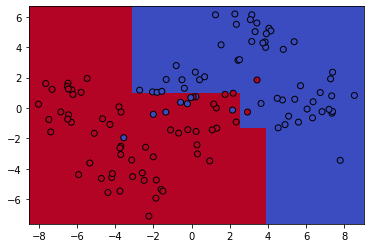

In [ ]:
plot_AdaBoost(X_test, y_test, classifiers_5, alphas_5)

Compute the accuracy of the predictions on the test set.

In [ ]:
acc_5 = accuracy_score(y_test, y_predn_5)
acc_5

0.907563025210084

Use the train_AdaBoost function to train an AdaBoost model with k=100.

In [ ]:
classifiers_100, alphas_100 = train_AdaBoost(X_train, y_train, 100)

Use the predict_AdaBoost function to make predictions on X_test.

In [ ]:
y_predn_100 = predict_AdaBoost(X_test, classifiers_100, alphas_100)

Use the plot_AdaBoost function to plot the learnt decision surface.

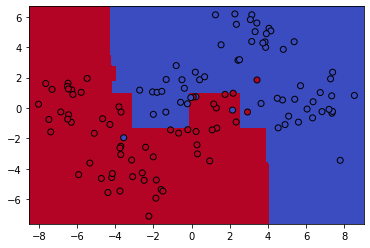

In [ ]:
plot_AdaBoost(X_test, y_test, classifiers_100, alphas_100)

Compute the accuracy of the predictions on the test set.

In [ ]:
acc_100 = accuracy_score(y_test, y_predn_100)
acc_100

0.9495798319327731